<img src="files/missionlogo.png">

# Intro to Working with ICESat-2 Data: MGL
The majority of learning resources featured in notebook come from the 2020 ICESat-2 Cryospheric Hackweek
2020 Hackweek Learning Resources GitHub: https://github.com/ICESAT-2HackWeek/learning-resources

### Authors
- Anna Valentine (annavalentine@mymail.mines.edu)
- Countless contributors of code from the Hackweek GitHub Repository



## ICESat-2 Mission: Satellite, Sensor, and Data
There's a lot of information out there to help us better understand the data we are looking at, and a quick google search of ICESat-2 will bring you a lot of information!




Some ICESat-2 websites to familiarize yourself with: 
- National Snow and Ice Data Center: https://nsidc.org/data/icesat-2 
- NASA:  https://icesat-2.gsfc.nasa.gov/

#### Hackweek Tutorial (~1hr) : https://www.youtube.com/watch?v=0guml7ihfdA 

In [5]:
from IPython.display import HTML
from IPython.display import Image

#Ignore warnings that come up with this link 
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/0guml7ihfdA" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

## Common Tools

Most people working with this data will use these basic tools to organize code, analyze, etc.:
- Python 
- GitHub  
- Jupyter Notebook



### Python 
Python is an interpreted, high-level, general-purpose programming language. It is the most commonly used language for looking at this kind of data, and the tools used to help with acessing/analyze data (captoolkit/icepyx) are written in python. It is also reccomended to use Anaconda, which is the recommended Python distribution, for installing and working with Python on your local computer. Conda is an open source package and environment management system for installing multiple versions of software packages, their dependencies and switching easily between them. While you can set up python without anaconda, conda makes it easier to install packages such as numpy, pandas, geopandas and other tools used in data analysis. 

Installation Instructions: https://icesat-2hackweek.github.io/learning-resources/preliminary/conda/ 

### Useful Packages (Python Libraries):
- matplotlib
- gdal
- h5py
- numpy
- pyproj
- icepyx

#### Installing with Conda:
1. Open an anaconda prompt (similar to a command line propmpt)
2. `conda install pckg-name`

*If you are having difficulty installing packages, look at documentation of said package, there may be other dependencies

**NOTE: to install GDAL, I would use OSGeo4W (https://trac.osgeo.org/osgeo4w/ ) , which will set up an environement for tools to work nicely together. **

### Installing IcePyx:
<img src="files/IcepyxInstall.JPG">

<img src="files/installmeme.jpg">

### GitHub/Git
Git is a popular version control system that is the foundation of most open source software development. GitHub is a hosting service for Git repositories, enabling us to share code across teams in a web environment. Once set-up, it's a good idea to ask your team if they have a GitHub team or repository that they will work from!

- Make a GitHub Account: https://github.com/ 

- Install Git: https://git-scm.com/

- Join the Mines Glaciology Lab GitHub: EMAIL MATT YOUR GITHUB USERNAME



#### IS2 Git/GitHub Tutorial: https://www.youtube.com/watch?v=O2lLC_s_d20&feature=youtu.be 



# Example Code

In [6]:
#Some of the libraries we need to import
import icepyx as ipx 
import os
import shutil
from pprint import pprint

# utility modules
import glob
import sys
import re

# the usual suspects:
import numpy as np
import matplotlib.pyplot as plt

# specialty modules
import h5py
import pyproj
%matplotlib inline

#For ATL06 Reader
from astropy.time import Time

#Some setup code
path = './download'

## Accessing Data using Icepyx

In [7]:
#First, we need to define where we want to look:
# A random patch
short_name = 'ATL06'                           #The data product, as described in data products chart 
spatial_extent = [-105, -77, -95, -73]       #Bounding box given in decimal degrees: lower left longitude, 
                                               #lower left latitude, upper right longitude, and upper right latitude.
date_range = ['2019-01-01','2019-03-01']       #Finally, our date range we want to look at 


region_a = ipx.Query(short_name, spatial_extent, date_range)  #We are defining the region we want data for


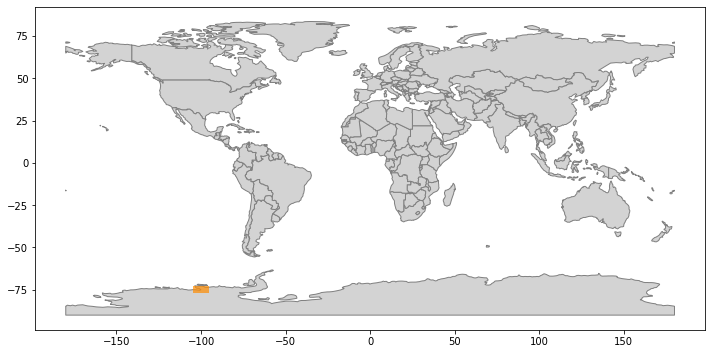

In [8]:
#Okay, but what am I even looking at? Let's use a tool from the icepyx library that easily allows us to see the spacial 
#extent of what we are looking at. Check out the lower left of map in orange!
region_a.visualize_spatial_extent() 

In [9]:
#First, we need to define where we want to look:
# Pine Island Glacier
short_name = 'ATL06'                           #The data product, as described in data products chart 
spatial_extent = [-105, -77, -95, -73]       #Bounding box given in decimal degrees: lower left longitude, 
                                               #lower left latitude, upper right longitude, and upper right latitude.
date_range = ['2019-01-01','2019-03-01']       #Finally, our date range we want to look at 


region_a = ipx.Query(short_name, spatial_extent, date_range)  #We are defining the region we want data for

In [ ]:
earthdata_uid = 'annavalentine'                #Put your Earthdata login info here
email = 'annavalentine@mymail.mines.edu'
region_a.earthdata_login(earthdata_uid, email)

In [ ]:
# And now we are going to download our "granules", these will end up in your ./downloads path

### We aren't actually going to run this, because it get's very confusing with the binder, ###
               ### but, you can do this on your own machine! ###

#region_a.download_granules(path)

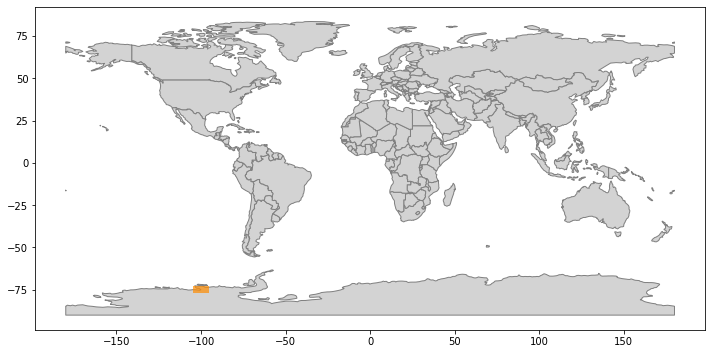

In [10]:
#Okay, but what am I even looking at? Let's use a tool from the icepyx library that easily allows us to see the spacial 
#extent of what we are looking at. Check out the lower left of map in orange!
region_a.visualize_spatial_extent() 

## Data Products & Types
ICESat-2 has many different data products, a quick summary:
- ATL03 : Terrain Elv. 
- ATL04: Lidar Backscatter
- ATL06: Glacier/Ice Sheet Elv. 
- ATL07: Sea Ice Elv. 
- ATL11: Time Series of Surface Heights


FULL TABLE HERE: https://nsidc.org/data/icesat-2/data-sets 

Once you know the dataset you are working with, check out it's data dictionary:

<img src="files/ATL06.jpg">

In [11]:
#ATL06 Reader:
#There are many different ATL06 readers, this is one I have been using, as it takes your data and puts each beam into 
# a seperate file (gt1r = 1, right)

#So, it is a good idea, once you have your data downloaded, to run through those .h5 files, to turn them into something
#a little more useful. 

#It's also meaningful to note that you can add more variables of interest by looking at their names in the data
#dictionary

#A common function used in the ATL06 reader
def gps2dyr(time):
    """ Converte GPS time to decimal years. """
    return Time(time, format='gps').decimalyear

def track_type(time, lat, tmax=1):
    """
    Separate tracks into ascending and descending.
    
    Defines tracks as segments with time breaks > tmax,
    and tests whether lat increases or decreases w/time.
    """
    tracks = np.zeros(lat.shape)  # generate track segment
    tracks[0:np.argmax(np.abs(lat))] = 1  # set values for segment
    i_asc = np.zeros(tracks.shape, dtype=bool)  # output index array

    # Loop trough individual secments
    for track in np.unique(tracks):
    
        i_track, = np.where(track == tracks)  # get all pts from seg
    
        if len(i_track) < 2: continue
    
        # Test if lat increases (asc) or decreases (des) w/time
        i_min = time[i_track].argmin()
        i_max = time[i_track].argmax()
        lat_diff = lat[i_track][i_max] - lat[i_track][i_min]
    
        # Determine track type
        if lat_diff > 0:  i_asc[i_track] = True
    
    return i_asc, np.invert(i_asc)  # index vectors

#ATL06 reader
def read_atl06(fname, bbox=None):
    """ 
    Read 1 ATL06 file and output 6 reduced files. 
    
    Extract variables of interest and separate the ATL06 file 
    into each beam (ground track) and ascending/descending orbits.
    """

    # Each beam is a group
    group = ['/gt1l', '/gt1r', '/gt2l', '/gt2r', '/gt3l', '/gt3r']

    # Loop trough beams
    for k,g in enumerate(group):
    
        #-----------------------------------#
        # 1) Read in data for a single beam #
        #-----------------------------------#
    
        # Load variables into memory (more can be added!)
        with h5py.File(fname, 'r') as fi:
            lat = fi[g+'/land_ice_segments/latitude'][:]
            lon = fi[g+'/land_ice_segments/longitude'][:]
            h_li = fi[g+'/land_ice_segments/h_li'][:]
            s_li = fi[g+'/land_ice_segments/h_li_sigma'][:]
            t_dt = fi[g+'/land_ice_segments/delta_time'][:]
            q_flag = fi[g+'/land_ice_segments/atl06_quality_summary'][:]
            s_fg = fi[g+'/land_ice_segments/fit_statistics/signal_selection_source'][:]
            snr = fi[g+'/land_ice_segments/fit_statistics/snr_significance'][:]
            h_rb = fi[g+'/land_ice_segments/fit_statistics/h_robust_sprd'][:]
            dac = fi[g+'/land_ice_segments/geophysical/dac'][:]
            f_sn = fi[g+'/land_ice_segments/geophysical/bsnow_conf'][:]
            dh_fit_dx = fi[g+'/land_ice_segments/fit_statistics/dh_fit_dx'][:]
            tide_earth = fi[g+'/land_ice_segments/geophysical/tide_earth'][:]
            tide_load = fi[g+'/land_ice_segments/geophysical/tide_load'][:]
            tide_ocean = fi[g+'/land_ice_segments/geophysical/tide_ocean'][:]
            tide_pole = fi[g+'/land_ice_segments/geophysical/tide_pole'][:]
            t_ref = fi['/ancillary_data/atlas_sdp_gps_epoch'][:]
            rgt = fi['/orbit_info/rgt'][:] * np.ones(len(lat))
            orb = np.full_like(h_li, k)

        #---------------------------------------------#
        # 2) Filter data according region and quality #
        #---------------------------------------------#
        
        # Select a region of interest
        if bbox:
            lonmin, lonmax, latmin, latmax = bbox
            bbox_mask = (lon >= lonmin) & (lon <= lonmax) & \
                        (lat >= latmin) & (lat <= latmax)
        else:
            bbox_mask = np.ones_like(lat, dtype=bool)  # get all
            
        # Only keep good data, and data inside bbox
        mask = (q_flag == 0) & (np.abs(h_li) < 10e3) & (bbox_mask == 1)
        
        # Update variables
        lat, lon, h_li, s_li, t_dt, h_rb, s_fg, snr, q_flag, f_sn, \
            tide_earth, tide_load, tide_ocean, tide_pole, dac, rgt, orb = \
                lat[mask], lon[mask], h_li[mask], s_li[mask], t_dt[mask], \
                h_rb[mask], s_fg[mask], snr[mask], q_flag[mask], f_sn[mask], \
                tide_earth[mask], tide_load[mask], tide_ocean[mask], \
                tide_pole[mask], dac[mask], rgt[mask], orb[mask]

        # Test for no data
        if len(h_li) == 0: continue

        #-------------------------------------#
        # 3) Convert time and separate tracks #
        #-------------------------------------#
        
        # Time in GPS seconds (secs sinde 1980...)
        t_gps = t_ref + t_dt

        # Time in decimal years
        t_year = gps2dyr(t_gps)

        # Determine orbit type
        i_asc, i_des = track_type(t_year, lat)
        
        #-----------------------#
        # 4) Save selected data #
        #-----------------------#
        
        # Define output file name
        ofile = fname.replace('.h5', '_'+g[1:]+'.h5')
                
        # Save variables
        with h5py.File(ofile, 'w') as f:
            f['orbit'] = orb
            f['lon'] = lon
            f['lat'] = lat
            f['h_elv'] = h_li
            f['t_year'] = t_year
            f['t_sec'] = t_gps
            f['s_elv'] = s_li
            f['h_rb'] = h_rb
            f['s_fg'] = s_fg
            f['snr'] = snr
            f['q_flg'] = q_flag
            f['f_sn'] = f_sn
            f['tide_load'] = tide_load
            f['tide_ocean'] = tide_ocean
            f['tide_pole'] = tide_pole
            f['tide_earth'] = tide_earth
            f['dac'] = dac
            f['rgt'] = rgt
            f['trk_type'] = i_asc
            
            print('out ->', ofile)

In [16]:
#Followed up by a very H5 reader for the output files we just produced using the ATL06 reader! 
def read_h5(fname, vnames=[]):
    """ Simple HDF5 reader. """
    with h5py.File(fname, 'r') as f:
        return [f[v][:] for v in vnames]
    

In [18]:
#RUN THIS BLOCK TO USE THE ATL06 READER
path = '*.h5' #This is a extremely general path, that finds all files in directory with .h5 extension

ATL06_files = glob.glob(path)  #Glob is a way to get a file list from a path

for f in ATL06_files:
    #print(f)
    read_atl06(f)


out -> ATL06_20181015192945_02620110_003_01-Copy1_gt1l.h5
out -> ATL06_20181015192945_02620110_003_01-Copy1_gt1r.h5
out -> ATL06_20181015192945_02620110_003_01-Copy1_gt2l.h5
out -> ATL06_20181015192945_02620110_003_01-Copy1_gt2r.h5
out -> ATL06_20181015192945_02620110_003_01-Copy1_gt3l.h5
out -> ATL06_20181015192945_02620110_003_01-Copy1_gt3r.h5
out -> ATL06_20181016081728_02700112_003_01-Copy1_gt1l.h5
out -> ATL06_20181016081728_02700112_003_01-Copy1_gt1r.h5
out -> ATL06_20181016081728_02700112_003_01-Copy1_gt2l.h5
out -> ATL06_20181016081728_02700112_003_01-Copy1_gt2r.h5
out -> ATL06_20181016081728_02700112_003_01-Copy1_gt3l.h5
out -> ATL06_20181016081728_02700112_003_01-Copy1_gt3r.h5
out -> ATL06_20181017075148_02850112_003_01-Copy1_gt1l.h5
out -> ATL06_20181017075148_02850112_003_01-Copy1_gt1r.h5
out -> ATL06_20181017075148_02850112_003_01-Copy1_gt2l.h5
out -> ATL06_20181017075148_02850112_003_01-Copy1_gt2r.h5
out -> ATL06_20181017075148_02850112_003_01-Copy1_gt3l.h5
out -> ATL06_2

## Transforming Coordinates
There are a bunch of "projections" out there, and depending on what you neeed/want to do, you may have to transform the 
latitude and longitudes between these projections: 

In [19]:
from pyproj import Transformer
def transform_coord(proj1, proj2, x, y): 
    """
    Transform coordinates from proj1 to proj2 (EPSG num).

    Example EPSG projs:
        Geodetic (lon/lat): 4326
        Polar Stereo AnIS (x/y): 3031
        Polar Stereo GrIS (x/y): 3413
    """
    #Set up proj 1 and proj2
    transformer = Transformer.from_crs(proj1, proj2, always_xy = True)
    return transformer.transform(x, y)
    

## Quick Visualizations of Data
Okay, now I have data, I know what it is (in ATL06's case: derived ice sheet elevations), how can I use it?

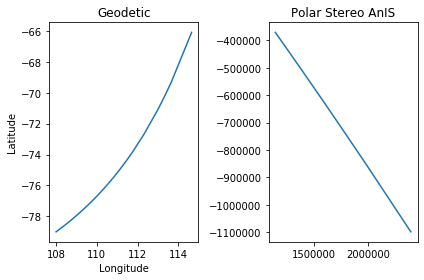

In [20]:
%matplotlib inline 
path = '*gt*.h5' #Earlier in this code, we downloaded some granules and sent them to this path

ATL06_files = glob.glob(path)  #Glob is a way to get a file list from a path

#Let's look at just one file first, using our ATL06 reader
test_file = ATL06_files[0]
lon, lat = read_h5(test_file, ['lon', 'lat'])

x, y = transform_coord(4326, 3031, lon, lat)

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(lon, lat)
ax1.set_title("Geodetic")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax2.plot(x, y)
ax2.set_title("Polar Stereo AnIS")

plt.tight_layout()

Text(0.5, 1.0, 'A single track')

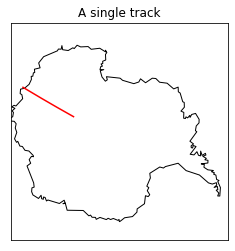

In [21]:
#Okay but those lines are pretty dang useless, unless we know where they are on the glacier? 
from mpl_toolkits.basemap import Basemap
fig = plt.figure()

m=Basemap(width=5400000., height=5400000., projection='stere',
          ellps='WGS84', lon_0=180., lat_0=-90., lat_ts=-71)

m.drawcoastlines()

x1, y1 = m(lon, lat)

plt.plot(x1, y1, color = 'red')
plt.title("A single track")

Text(0.5, 1.0, 'Crossovers')

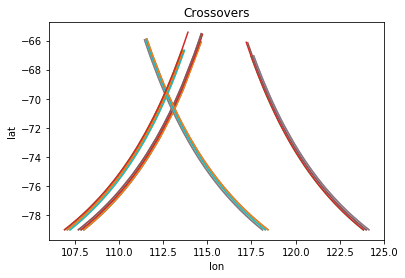

In [22]:
#Okay, how about if we look at multiple files at once, by plotting just long and lat, we can see their crossovers!

for fname in ATL06_files:
    try:
        lon, lat = read_h5(fname, ['lon', 'lat'])
        plt.plot(lon, lat)
        
    except: 
        pass
     
plt.xlabel('lon')
plt.ylabel('lat')
plt.title("Crossovers")

Text(0.5, 1.0, 'Area of Data')

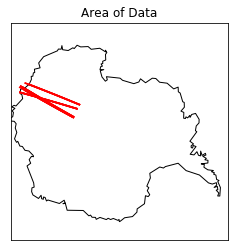

In [23]:
#Okay so where is this patch on our awesome Basemap Projection? 
fig = plt.figure()

m=Basemap(width=5400000., height=5400000., projection='stere',
          ellps='WGS84', lon_0=180., lat_0=-90., lat_ts=-71)

m.drawcoastlines()

for fname in ATL06_files:
    try:
        lon, lat = read_h5(fname, ['lon', 'lat'])
        x1, y1 = m(lon, lat)
        plt.plot(x1, y1, color = 'red')
        
    except: 
        pass

plt.title("Area of Data")
    
#Dang, that's a lot of cross overs and that's just a small part of Antarctica!

## Elevation data and other variables

Text(0, 0.5, 'Elvation (m)')

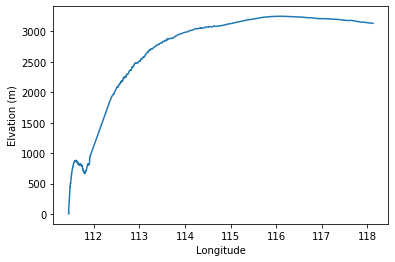

In [24]:
# One particularly useful feature in matplotlib is being able to make your plot interactive,
#especially for looking at data loss:

#%matplotlib notebook  
%matplotlib inline


lon, lat, elv = read_h5(ATL06_files[6], ['lon', 'lat', 'h_elv'])

plt.plot(lon, elv)
plt.xlabel("Longitude")
plt.ylabel("Elvation (m)")



## More Example Notebooks : 
- ICESat-2 Hackweek Tutorials: https://github.com/ICESAT-2HackWeek/2020_ICESat-2_Hackweek_Tutorials
- Icepyx Tutorials: https://github.com/icesat2py/icepyx/tree/development/examples
- Anna's Repo of Random Code: 